In [2]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
def read_vid():
    print("Enter file name: ")
    url = input()
    cap = cv.VideoCapture(url)
    if not cap.isOpened():
        print("Cannot open file")
        exit()
    return cap

## Image Processing
#### detecting edges (for approach1);

In [4]:
def process(frame):
    img = np.copy(frame)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    #gray = cv.adaptiveThreshold(gray,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,7,7)
    blur = cv.GaussianBlur(gray,(5,5),0)
    canny = cv.Canny(blur,50,100)
    i = canny
    return i

In [5]:
def process1(frame):
    img = np.copy(frame)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    eq = cv.equalizeHist(gray)
    #eq = clahe.apply(gray)
    #th = cv.adaptiveThreshold(eq,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,7)
    ret,th = cv.threshold(eq,180,255,cv.THRESH_BINARY)
    blur = cv.GaussianBlur(th,(5,5),0)
    canny = cv.Canny(blur,50,100)
    i = canny
    return i

#### thresholding important features

In [6]:
#yellow and white
def process2(frame):
    l1 = np.array([100,100,200],dtype=np.uint8)
    u1 = np.array([255,255,255],dtype=np.uint8)
    l2 = np.array([0,180,255],dtype=np.uint8)
    u2 = np.array([170,255,255],dtype=np.uint8)
    l3 = np.array([20,120,80],dtype=np.uint8)
    u3 = np.array([45,200,255],dtype=np.uint8)
    
    mask1 = cv.inRange(frame,l1,u1)
    mask2 = cv.inRange(frame,l2,u2)
    mask3 = cv.inRange(cv.cvtColor(frame,cv.COLOR_BGR2HLS),l3,u3)
    mask = cv.bitwise_or(mask1,mask2)
    mask = cv.bitwise_or(mask,mask3)
    
    blur = cv.GaussianBlur(mask,(5,5),0)
    canny = cv.Canny(blur,50,100)
    i = canny
    return mask

In [64]:
def threshold_rel(img,l,h):
    vmin = np.min(img)
    vmax = np.max(img)
    lo = vmin + (vmax-vmin)*l
    hi = vmin + (vmax-vmin)*h
    return np.uint8((img>=lo)&(img<=hi))*255

def threshold_abs(img,l,h):
    return np.uint8((img>=l)&(img<=h))*255

def process3(frame):
    hls = cv.cvtColor(frame,cv.COLOR_BGR2HLS)
    hsv = cv.cvtColor(frame,cv.COLOR_BGR2HSV)
    h = hls[:,:,0]
    l = hls[:,:,1]
    s = hls[:,:,2]
    v = hsv[:,:,2]
    
    right_lane = threshold_rel(l, 0.8, 1.0)
    right_lane[:,:750] = 0
    
    left_lane = threshold_abs(h, 20, 30)
    left_lane &= threshold_rel(v, 0.7, 1.0)
    left_lane[:,550:] = 0
    
    mask = left_lane | right_lane
    
    
    blur = cv.GaussianBlur(mask,(5,5),0)
    canny = cv.Canny(blur,50,100)
    i = canny
    return mask

In [8]:
#roi for approach1
def region_of_interest(img,pts=[(170,700),(1150,700),(700,450)]):
    polygons = np.array([pts])
    mask = np.zeros_like(img)
    cv.fillPoly(mask,polygons,255)
    masked_img = cv.bitwise_and(img,mask)
    return masked_img

In [9]:
#warp perspective
def transform_backward(img,pts=None):
    x_size = img.shape[1]
    y_size = img.shape[0]
    if pts is None:
        mid_x = x_size//2
        top_y = 2*y_size//3
        top_margin = 93
        bottom_margin = 450
        pts = ([(mid_x-top_margin,top_y),(mid_x+top_margin,top_y),(mid_x-bottom_margin,y_size),(mid_x+bottom_margin,y_size)],
               [(mid_x-bottom_margin,0),(mid_x+bottom_margin,0),(mid_x-bottom_margin,y_size),(mid_x+bottom_margin,y_size)])
        
    pts1 = np.float32(pts[1])
    pts2 = np.float32(pts[0])
    M = cv.getPerspectiveTransform(pts1,pts2)
    new = cv.warpPerspective(img,M,(x_size,y_size),flags=cv.INTER_LINEAR)
    
    return new

In [10]:
#warp perspective
def transform_forward(img,pts=None):
    x_size = img.shape[1]
    y_size = img.shape[0]
    if pts is None:
        mid_x = x_size//2
        top_y = 2*y_size//3
        top_margin = 93
        bottom_margin = 450
        pts = ([(mid_x-top_margin,top_y),(mid_x+top_margin,top_y),(mid_x-bottom_margin,y_size),(mid_x+bottom_margin,y_size)],
               [(mid_x-bottom_margin,0),(mid_x+bottom_margin,0),(mid_x-bottom_margin,y_size),(mid_x+bottom_margin,y_size)])
        
    pts1 = np.float32(pts[0])
    pts2 = np.float32(pts[1])
    M = cv.getPerspectiveTransform(pts1,pts2)
    new = cv.warpPerspective(img,M,(x_size,y_size),flags=cv.INTER_LINEAR)
    
    return new

In [11]:
def find_coordinates(img,p):
    m = p[0]
    c = p[1]
    y1 = img.shape[0]
    y2 = int(y1 * (3/5))
    x1 = int((y1-c)/m)
    x2 = int((y2-c)/m)
    return np.array([[x1,y1,x2,y2]])

In [12]:
def draw_lines(img,lines,full=None):
    lane_img = np.zeros_like(img)
    if lines is not None:
        for line in lines:
            x1,y1,x2,y2 = line.reshape(4)
            if (full is None) or (full == 0):
                cv.line(lane_img,(x1,y1),(x2,y2),(0,0,255),5)
            else:
                p = np.polyfit((x1,y1),(x2,y2),1)
                x1,y1,x2,y2 = find_coordinates(img,p).reshape(4)
                cv.line(lane_img,(x1,y1),(x2,y2),(0,0,255),5)
    return lane_img

In [13]:
def average_lines(img,lines):
    left = []
    right = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        p = np.polyfit((x1,y1),(x2,y2),1)
        m = p[0]
        c = p[1]
        if m<0:
            left.append((m,c))
        elif m>0:
            right.append((m,c))
    
    left_avg = np.average(left,axis=0)
    right_avg = np.average(right,axis=0)
    left_line = find_coordinates(img,left_avg)
    right_line = find_coordinates(img,right_avg)
    return np.array((left_line,right_line))

In [30]:
#approach2: sliding window method
def find_lane(img,nwindows=10,margin=80,minpix=None):
    if minpix is None:
        minpix = margin*2
    assert (img.ndim == 2)
    new_bin = np.zeros_like(img)
    new_bin[img>0] = 1
    
    out = np.copy(cv.cvtColor(img,cv.COLOR_GRAY2BGR))
    out[out>0] = 255
    
    histogram = np.sum(new_bin[new_bin.shape[0]//2000:,:],axis=0)
    mid = histogram.shape[0]//2
    left_x = np.argmax(histogram[:mid])
    right_x = np.argmax(histogram[mid:]) + mid
    
    #find nonzero pixel index number in image (coordinates of bright)
    win_height = new_bin.shape[0]//nwindows
    nonzero = new_bin.nonzero()
    nonzero_x = np.array(nonzero[1])
    nonzero_y = np.array(nonzero[0])
    
    left_lane_ind = []
    right_lane_ind = []
    #find windows
    for win in range(nwindows):
        win_y_low = new_bin.shape[0] - (win+1)*win_height
        win_y_high = new_bin.shape[0] - win*win_height
        win_x_left_low = max(0,left_x-margin)
        win_x_left_high = left_x+margin
        win_x_right_low = right_x - margin
        win_x_right_high = min(new_bin.shape[1]-1,right_x+margin)
        
        #draw rectangel:
        cv.rectangle(out,(win_x_left_low,win_y_high),(win_x_left_high,win_y_low),(0,255,0),3)
        cv.rectangle(out,(win_x_right_low,win_y_high),(win_x_right_high,win_y_low),(0,255,0),3)
        
        #non-zero pixel within the windows, returned as positions(index) in nonzero_x 
        left_ind = ((nonzero_y>=win_y_low) & (nonzero_y<=win_y_high) &
                    (nonzero_x>=win_x_left_low) & (nonzero_x<=win_x_left_high)).nonzero()[0]
        right_ind = ((nonzero_y>=win_y_low) & (nonzero_y<=win_y_high) &
                     (nonzero_x>=win_x_right_low) & (nonzero_x<=win_x_right_high)).nonzero()[0]
        left_lane_ind.append(left_ind)
        right_lane_ind.append(right_ind)
        
        #re-align centre
        if len(left_ind)>= minpix:
            left_x = int(np.mean(nonzero_x[left_ind]))
        if len(right_ind)>=minpix:
            right_x = int(np.mean(nonzero_x[right_ind]))
            
    #concatenate array of index of pixels inside all boxes
    left_lane_ind = np.concatenate(left_lane_ind)
    right_lane_ind = np.concatenate(right_lane_ind)
    
    #coordinates of final "good pixels" i.e inside the boxes
    left_x = nonzero_x[left_lane_ind]
    left_y = nonzero_y[left_lane_ind]
    right_x = nonzero_x[right_lane_ind]
    right_y = nonzero_y[right_lane_ind]
    
    #color the good pixels
    out[left_y,left_x] = [255,0,0]
    out[right_y,right_x] = [0,0,255]
    
    #fit 2nd order poly
    left_fit,right_fit = np.array([]),np.array([])
    
    if (left_y.size!=0) and (left_x.size!=0):
        left_fit = np.polyfit(left_y,left_x,2)
    if (right_y.size!=0) and (right_x.size!=0):
        right_fit = np.polyfit(right_y,right_x,2)
    
    
    #get coordinates of poly
    y_val = np.linspace(0,new_bin.shape[0]-1,new_bin.shape[0])
    left_x_val,right_x_val = np.array([]),np.array([])
    if left_fit.size!=0:
        left_x_val = left_fit[0]*y_val**2 + left_fit[1]*y_val + left_fit[2]
    if right_fit.size!=0:
        right_x_val = right_fit[0]*y_val**2 + right_fit[1]*y_val + right_fit[2]
    
    #draw poly
    #left_points,right_points = np.array([]),np.array([])
    if left_x_val.size!=0:
        left_points = np.array([np.vstack([left_x_val,y_val]).T])
        pts = np.array(left_points.squeeze(),np.int32)
        pts.reshape((-1,1,2))
        cv.polylines(out,[pts],False,(254,0,0),50)
    if right_x_val.size!=0:
        right_points = np.array([np.flipud(np.vstack([right_x_val,y_val]).T)])
        pts = np.array(right_points.squeeze(),np.int32)
        pts.reshape((-1,1,2))
        cv.polylines(out,[pts],False,(254,0,0),50)
    lane = np.copy(out)
    lane[out==255] = 0
    if (left_x_val.size!=0) and (right_x_val.size!=0):
        pts = np.hstack((left_points,right_points))
        cv.fillPoly(lane,np.int_([pts]),(0,254,0))
    return out,lane

Enter file name: 
lane1.mp4


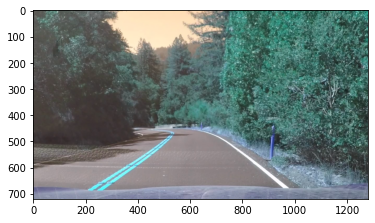

In [123]:
#take input file
capt = read_vid()
_,frame = capt.read()
plt.imshow(frame)
plt.imshow(frame)

In [78]:
#apporach1: basic roi and edges
cap = capt
while True:
    _,frame = cap.read()
    if not _:
        break
    roi = region_of_interest(process2(frame))
    lines = cv.HoughLinesP(roi,2,np.pi/180,100,np.array([]),minLineLength=40,maxLineGap=5)
    #avg_lines = average_lines(frame,lines)
    final = cv.addWeighted(frame,0.8,draw_lines(frame,lines),1,1)
    cv.imshow('hey',final)
    k = cv.waitKey(1)
    if k == ord('q'):
        break
    if k == ord('p'):
        cv.waitKey(0)

#cap.release()
cv.destroyAllWindows()

In [125]:
#approach 2: sliding window on detected yellow and white
cap = capt
fourcc = cv.VideoWriter_fourcc(*'MJPG')
#output = cv.VideoWriter('output2.avi',fourcc,30.0,(1280,720))
while True:
    _,frame = cap.read()
    if not _:
        break
    new = process3(transform_forward(frame))
    #lines = cv.HoughLinesP(new,2,np.pi/180,100,np.array([]),minLineLength=40,maxLineGap=5)
    #avg_lines = average_lines(frame,lines)
    #lanes = transform_backward(draw_lines(frame,lines))
    out,lanes = find_lane(new)
    lanes = transform_backward(lanes)
    final = cv.addWeighted(frame,1,lanes,0.35,1)
    cv.imshow('birds eye',cv.resize(out,(250,300)))
    cv.imshow('result',final)
    #cv.imshow('t',cv.resize(process(transform_forward(frame)),(250,300)))
    #output.write(final.astype('uint8'))
    k = cv.waitKey(1)
    if k == ord('q'):
        break
    if k == ord('p'):
        cv.waitKey(0)

cap.release()
#output.release()
cv.destroyAllWindows()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]
/usr/lib/python3/dist-packages/ipykernel_launcher.py:13: RankWarning: Polyfit may be poorly conditioned
  del sys.path[0]


In [37]:
pts = ([(550,460),(770,460),(150,720),(1200,720)],
      [(100,0),(1100,0),(100,720),(1100,720)])

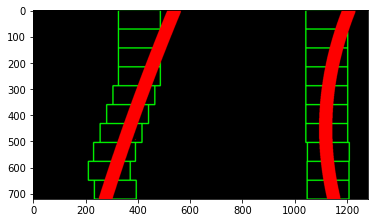

In [105]:
new = process2(transform_forward(frame))
a,b = find_lane(new)
plt.imshow(a)

In [106]:
frame.shape

(720, 1280, 3)